# AVO Explorer v2 (mono)

Jupyter notebook to explore AVO classes.

Monolytic version, made to be run without any Python installed on local pc using [colab.research.google.com](https://colab.research.google.com): no dependency from external libraries, no interactive widgets (ipywidgets are not yet supported by colab).

Bookmark the following link to reuse this notebook: <https://colab.research.google.com/github/aadm/geophysical_notes/blob/master/avo_explorer_v2_mono.ipynb>

2016-2018, Alessandro Amato del Monte (alessandro.adm@gmail.com)

***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The cell below defines the elastic properties for the various AVO classes, taken from Castagna & Swan, "Principles of AVO crossplotting" (1997) and Hilterman, "Seismic Amplitude Interpretation" (2001).

In [2]:
shale = np.array([[3094,1515,2.40], [2643,1167,2.29], [2192,818,2.16], [3240,1620,2.34]])
ssgas = np.array([[4050,2526,2.21,.2], [2781,1665,2.08,.25], [1542,901,1.88,.33], [1650,1090,2.07,.18]])
ssbri = np.array([[4115,2453,2.32,.2], [3048,1595,2.23,.25], [2134,860,2.11,.33], [2590,1060,2.21,.18]])
avocl=['class 1','class 2','class 3','class 4']

The following cell define some support functions: `ricker` (to create wavelets), `gassmann` (to perform fluid substitution), `shuey` and `ruger` (reflectivity equations for the isotropic and anisotropic case).

In [3]:
def ricker(f, length, dt):
    '''
    (taken from https://github.com/seg/tutorials-2014/blob/master/1406_Make_a_synthetic/how_to_make_synthetic.ipynb)
    (author: Evan Bianco)
    '''
    t = np.linspace(-length/2, (length-dt)/2, int(length/dt))
    y = (1. - 2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y

def gassmann(vp1, vs1, rho1, rho_fl1, k_fl1, rho_fl2, k_fl2, k0, phi):
    '''
    written by Alessandro Amato del Monte, 2016
    '''
    vp1 = vp1/1000
    vs1 = vs1/1000
    rho2 = rho1-phi*rho_fl1+phi*rho_fl2
    mu1 = rho1*vs1**2.
    k1 = rho1*vp1**2-(4./3.)*mu1
    kdry= (k1 * ((phi*k0)/k_fl1+1-phi)-k0) / ((phi*k0)/k_fl1+(k1/k0)-1-phi)
    k2 = kdry + (1- (kdry/k0))**2 / ( (phi/k_fl2) + ((1-phi)/k0) - (kdry/k0**2) )
    mu2 = mu1
    vp2 = np.sqrt(((k2+(4./3)*mu2))/rho2)
    vs2 = np.sqrt((mu2/rho2))
    return [vp2*1000, vs2*1000, rho2, k2, kdry]

def ruger(vp1,vs1,rho1,d1,e1,vp2,vs2,rho2,d2,e2,theta):
    '''
    written by Alessandro Amato del Monte, 2016
    '''
    a = np.radians(theta)
    vp  = np.mean([vp1,vp2])
    vs  = np.mean([vs1,vs2])
    rho = np.mean([rho1,rho2])
    z   = np.mean([vp1*rho1,vp2*rho2])
    g   = np.mean([rho1*vs1**2,rho2*vs2**2])
    dvp = vp2-vp1
    dvs = vs2-vs1
    drho= rho2-rho1
    z2, z1 = vp2*rho2, vp1*rho1
    dz  = z2-z1
    dg  = rho2*vs2**2 - rho1*vs1**2
    dd = d2-d1
    de = e2-e1
    A = 0.5*(dz/z)
    B = 0.5*(dvp/vp - (2*vs/vp)**2 * (dg/g) + dd) * np.sin(a)**2
    C = 0.5*(dvp/vp + de) * np.sin(a)**2 * np.tan(a)**2
    R = A+B+C
    return R

def shuey(vp1, vs1, rho1, vp2, vs2, rho2, theta, approx=True, terms=False):
    '''
    shuey (C) aadm 2016
    Calculates P-wave reflectivity with Shuey's equation

    reference:
    Avseth et al. (2005), Quantitative Seismic Interpretation, Cambridge University Press (p.182)

    INPUT
    vp1, vs1, rho1: P-, S-wave velocity (m/s) and density (g/cm3) of upper medium
    vp2, vs2, rho2: P-, S-wave velocity (m/s) and density (g/cm3) of lower medium
    theta: angle of incidence (degree)
    approx: returns approximate (2-term) form (default: True)
    terms: returns reflectivity, intercept and gradient (default: False)

    OUTPUT
    reflectivity (and optionally intercept, gradient; see terms option) at angle theta
    '''
    a = np.radians(theta)
    dvp = vp2-vp1
    dvs = vs2-vs1
    drho = rho2-rho1
    vp  = np.mean([vp1,vp2])
    vs  = np.mean([vs1,vs2])
    rho = np.mean([rho1,rho2])
    R0 = 0.5*(dvp/vp + drho/rho)
    G  = 0.5*(dvp/vp) - 2*(vs**2/vp**2)*(drho/rho+2*(dvs/vs))
    F =  0.5*(dvp/vp)
    if approx:
        R = R0 + G*np.sin(a)**2
    else:
        R = R0 + G*np.sin(a)**2 + F*(np.tan(a)**2-np.sin(a)**2)
    if terms:
        return R,R0,G
    else:
        return R

The four main functions are `make_avoclasses` (plots a reference chart with the AVO classes), `avomod1` (creation of AVO curves, synthetic gather and Intercept-Gradient crossplot for a half-space model), `avomod2` (like the previous but allows for two different configurations for the lower medium, usually different fluids), `make_avo_explorer` (uses `avomod2` to give ... a simple selection to plot the reference AVO classes given by Hilterman (2001) for shale/brine sand scenarios and performs fluid replacement to make gas and oil sands)

In [4]:
def make_avoclasses(brine=False):
    '''
    written by Alessandro Amato del Monte, 2016
    '''
    ang = np.arange(0,50,1)
    cc = ['m','c','r','g']
    f,ax=plt.subplots(1,2, figsize=(10, 5))
    if brine:
        print('In the Intercept-Gradient crossplot, circles are gas sands, squares are brine sands.')
    for i, val in enumerate(avocl):
        amp0 = shuey(shale[i,0],shale[i,1],shale[i,2],ssbri[i,0],ssbri[i,1],ssbri[i,2],ang)
        amp1 = shuey(shale[i,0],shale[i,1],shale[i,2],ssgas[i,0],ssgas[i,1],ssgas[i,2],ang)
        tmp0 = shuey(shale[i,0],shale[i,1],shale[i,2],ssbri[i,0],ssbri[i,1],ssbri[i,2],30,terms=True)
        tmp1 = shuey(shale[i,0],shale[i,1],shale[i,2],ssgas[i,0],ssgas[i,1],ssgas[i,2],30,terms=True)
        Ib, Gb = tmp0[1],tmp0[2]
        Ig, Gg = tmp1[1],tmp1[2]
        ax[0].plot(ang, amp1, color=cc[i], lw=2, ls='-', label=val+' (gas)')
        ax[0].axhline(0, color='k')
        ax[0].set_xlabel('angle of incidence'), ax[0].set_ylabel('amplitude')
        ax[0].set_xlim(0, 40)
        ax[0].text(2,amp1[0]-.02,avocl[i], style='italic', fontsize=10, ha='left', va='top')
        ax[1].plot(Ig, Gg, color=cc[i], marker='o', ms=10, label=val+' (gas)')
        ax[1].axhline(0, color='k'), ax[1].axvline(0, color='k')
        ax[1].set_xlabel('intercept'), ax[1].set_ylabel('gradient')
        ax[1].set_xlim(-.5, .5)
        if brine:
            ax[0].plot(ang, amp0, color=cc[i], lw=2, ls='--', label=val+' (brine)')
            ax[1].plot(Ib, Gb, color=cc[i], marker='s', ms=10, label=val+' (brine)')
        # draw avo classes areas
        cl1_area = patches.Rectangle((0.02,-1),.98,1,edgecolor='None',facecolor='m',alpha=0.2)
        cl2_area = patches.Rectangle((-0.02,-1),.04,2,edgecolor='None',facecolor='c',alpha=0.2)
        cl3_area = patches.Rectangle((-1,-1),.98,1,edgecolor='None',facecolor='r',alpha=0.2)
        cl4_area = patches.Rectangle((-1,0),.98,1,edgecolor='None',facecolor='g',alpha=0.2)
        for aa in ax:
            aa.grid()
            aa.set_ylim(-.5, .5)
    background = patches.Polygon([[-1, 1], [1, -1], [1, 1]],facecolor='w')
    ax[1].add_patch(cl1_area)
    ax[1].add_patch(cl2_area)
    ax[1].add_patch(cl3_area)
    ax[1].add_patch(cl4_area)
    ax[1].add_patch(background)
    ax[1].text(.15,-.3,'Class 1',ha='center',va='center',color='m',style='italic')
    ax[1].text(0,-.25,'Class 2/2p',ha='center',va='center', color='c',style='italic')
    ax[1].text(-.35,-.3,'Class 3',ha='center',va='center', color='r',style='italic')
    ax[1].text(-.35,.15,'Class 4',ha='center',va='center', color='g',style='italic')

def avomod1(vp1,vs1,rho1,vp2,vs2,rho2,angmin=0,angmax=30,polarity='normal',black=False,mx=0.5):
    '''
    written by Alessandro Amato del Monte, 2016
    '''
    n_samples = 500
    gain=10
    interface=int(n_samples/2)
    ang = np.arange(angmin,angmax+1,1)
    z = np.arange(n_samples)

    # build Ip and Vp/Vs logs
    ip, vpvs = (np.zeros(n_samples) for _ in range(2))
    ip[:interface] = vp1*rho1
    ip[interface:] = vp2*rho2
    vpvs[:interface] = vp1/vs1
    vpvs[interface:] = vp2/vs2

    # calculate avo curve, intercept and gradient
    avo = shuey(vp1,vs1,rho1,vp2,vs2,rho2,ang)
    _,I,G = shuey(vp1,vs1,rho1,vp2,vs2,rho2,30,terms=True)

    # create synthetic gather
    _,wavelet = ricker(f=10, length=.250, dt=0.001)
    if polarity is not 'normal':
        avo *= -1

    # builds prestack gather model
    rc, syn = (np.zeros((n_samples,ang.size)) for _ in range(2))
    rc[interface,:]=  avo
    for i in range(ang.size):
        syn[:,i] = np.convolve(rc[:,i],wavelet,mode='same')

    # do the plot
    f=plt.subplots(figsize=(10, 5))
    ax0 = plt.subplot2grid((1,7), (0,0), colspan=1)
    ax1 = plt.subplot2grid((1,7), (0,1), colspan=1)
    ax2 = plt.subplot2grid((1,7), (0,2), colspan=1)
    ax3 = plt.subplot2grid((1,7), (0,3), colspan=2)
    ax4 = plt.subplot2grid((1,7), (0,5), colspan=2)
    ax0.plot(ip, z, '-k', lw=4)
    ax0.set_xlabel('AI [m/s*g/cc]')
    ax0.margins(x=0.5)
    ax1.plot(vpvs, z, '-k', lw=4)
    ax1.set_xlabel('Vp/Vs')
    ax1.margins(x=0.5)
    opz1={'color':'k','linewidth':2}
    opz2={'linewidth':0, 'alpha':0.6}
    for i in range(0,int(ang.size),10):
        trace=gain*syn[:,i] / np.max(np.abs(syn))
        ax2.plot(i+trace,z,**opz1)
        if black==False:
            ax2.fill_betweenx(z,trace+i,i,where=trace+i>i,facecolor=[0.6,0.6,1.0],**opz2)
            ax2.fill_betweenx(z,trace+i,i,where=trace+i<i,facecolor=[1.0,0.7,0.7],**opz2)
        else:
            ax2.fill_betweenx(z,trace+i,i,where=trace+i>i,facecolor='black',**opz2)
        ax2.set_xticklabels([])
    ax2.margins(x=0.05)
    ax3.plot(ang, avo,'-k', lw=4)
    ax3.axhline(0, color='k', lw=1)
    ax3.set_xlabel('angle of incidence')
    ax3.set_ylim(-mx,mx)
    ax4.plot(I,G,'ko',ms=10,mfc='none',mew=2)
    ax4.axhline(0, color='k', lw=1), ax4.axvline(0, color='k', lw=1)
    ax4.set_xlabel('intercept'), ax4.set_ylabel('gradient')
    ax4.set_xlim(-mx,mx), ax4.set_ylim(-mx,mx)
    ax4.xaxis.set_label_position('top'), ax4.xaxis.tick_top()
    ax4.yaxis.set_label_position('right'), ax4.yaxis.tick_right()
    for aa in [ax0, ax1, ax2]:
        aa.invert_yaxis()
        aa.xaxis.tick_top()
        plt.setp(aa.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
        aa.set_yticklabels([])
    plt.tight_layout()

def avomod2(vp1,vs1,rho1,vp2A,vs2A,rho2A,vp2B,vs2B,rho2B,angmin=0,angmax=30):
    '''
    written by Alessandro Amato del Monte, 2016
    '''
    n_samples = 500
    interface = int(n_samples/2)
    ang = np.arange(angmin,angmax+1,1)
    z = np.arange(n_samples)

    # builds Ip and Vp/Vs logs
    ipA,ipB,vpvsA,vpvsB = (np.zeros(n_samples) for _ in range(4))
    ipA[:interface] = vp1*rho1
    ipA[interface:] = vp2A*rho2A
    ipB[:interface] = vp1*rho1
    ipB[interface:] = vp2B*rho2B
    vpvsA[:interface] = vp1/vs1
    vpvsA[interface:] = vp2A/vs2A
    vpvsB[:interface] = vp1/vs1
    vpvsB[interface:] = vp2B/vs2B

    # calculates avo curve, intercept and gradient
    avoA = shuey(vp1,vs1,rho1,vp2A,vs2A,rho2A,ang)
    avoB = shuey(vp1,vs1,rho1,vp2B,vs2B,rho2B,ang)
    tmp0= shuey(vp1,vs1,rho1,vp2A,vs2A,rho2A,30,terms=True)
    IA, GA = tmp0[1],tmp0[2]
    tmp0= shuey(vp1,vs1,rho1,vp2B,vs2B,rho2B,30,terms=True)
    IB, GB = tmp0[1],tmp0[2]

    # do the plot
    f=plt.subplots(figsize=(10, 5))
    ax0 = plt.subplot2grid((1,6), (0,0), colspan=1)
    ax1 = plt.subplot2grid((1,6), (0,1), colspan=1)
    ax2 = plt.subplot2grid((1,6), (0,2), colspan=2)
    ax3 = plt.subplot2grid((1,6), (0,4), colspan=2)
    ax0.plot(ipB, z, '-r', lw=4)
    ax0.plot(ipA, z, '-k', lw=4)
    ax0.set_xlabel('AI [m/s*g/cc]')
    ax0.margins(x=0.5)
    ax1.plot(vpvsB, z, '-r', lw=4)
    ax1.plot(vpvsA, z, '-k', lw=4)
    ax1.set_xlabel('Vp/Vs')
    ax1.margins(x=0.5)
    ax2.plot(ang, avoB,'-r', lw=4)
    ax2.plot(ang, avoA,'-k', lw=4)
    ax2.axhline(0, color='k', lw=1)
    ax2.set_xlabel('angle of incidence')
    ax2.margins(y=0.5)
    ax3.plot(IB,GB,'ro',ms=15,mfc='r',mew=1)
    ax3.plot(IA,GA,'ko',ms=15,mfc='k',mew=1)
    ax3.axhline(0, color='k', lw=1), ax3.axvline(0, color='k', lw=1)
    ax3.set_xlabel('intercept'), ax3.set_ylabel('gradient')
    ax3.margins(0.5)
    ax3.xaxis.set_label_position('top'), ax3.xaxis.tick_top()
    ax3.yaxis.set_label_position('right'), ax3.yaxis.tick_right()
    for aa in [ax0, ax1]:
        aa.invert_yaxis()
        aa.xaxis.tick_top()
        plt.setp(aa.xaxis.get_majorticklabels(), rotation=90, fontsize=8)
        aa.set_yticklabels([])
    plt.tight_layout()

def make_avo_explorer(avoclass=3, fluid='gas', phimod=0.0):
    '''
    written by Alessandro Amato del Monte, 2016
    '''
    shale = np.array([[3094,1515,2.40], [2643,1167,2.29], [2192,818,2.16], [3240,1620,2.34]])
    ssbri = np.array([[4115,2453,2.32,.2], [3048,1595,2.23,.25], [2134,860,2.11,.33], [2590,1060,2.21,.18]])
    vp1,vs1,rho1 = shale[avoclass-1,0],shale[avoclass-1,1],shale[avoclass-1,2]
    vp2,vs2,rho2 = ssbri[avoclass-1,0],ssbri[avoclass-1,1],ssbri[avoclass-1,2]
    phi2 = ssbri[avoclass-1,3]+phimod

    # elastic parameters for toy-fluid replacement
    k0 = 37.00
    rhob, kb = 1.09,  2.20
    if fluid is 'gas':
        rhof_new, kf_new = 0.40,  0.02 # gas density & bulk modulus
    else:
        rhof_new, kf_new = 0.80,  1.02 # oil density & bulk modulus

    vp2B,vs2B,rho2B,_,_ = gassmann(vp2, vs2, rho2, rhob, kb, rhof_new, kf_new, k0, phi2)

    print('Shale:  Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(vp1,vs1,rho1))
    print('Sand (brine): Vp={:.0f}, Vs={:.0f}, rho={:.2f}, porosity={:.2f}'.format(vp2,vs2,rho2,phi2))
    print('Sand ({:s}): Vp={:.0f}, Vs={:.0f}, rho={:.2f}'.format(fluid,vp2B,vs2B,rho2B))

    avomod2(vp1,vs1,rho1,vp2,vs2,rho2,vp2B,vs2B,rho2B,angmin=0,angmax=30)

## AVO classes

The function `make_avoclasses` simply plots all the AVO classes in the amplitude vs angle domain and intercept vs gradient.

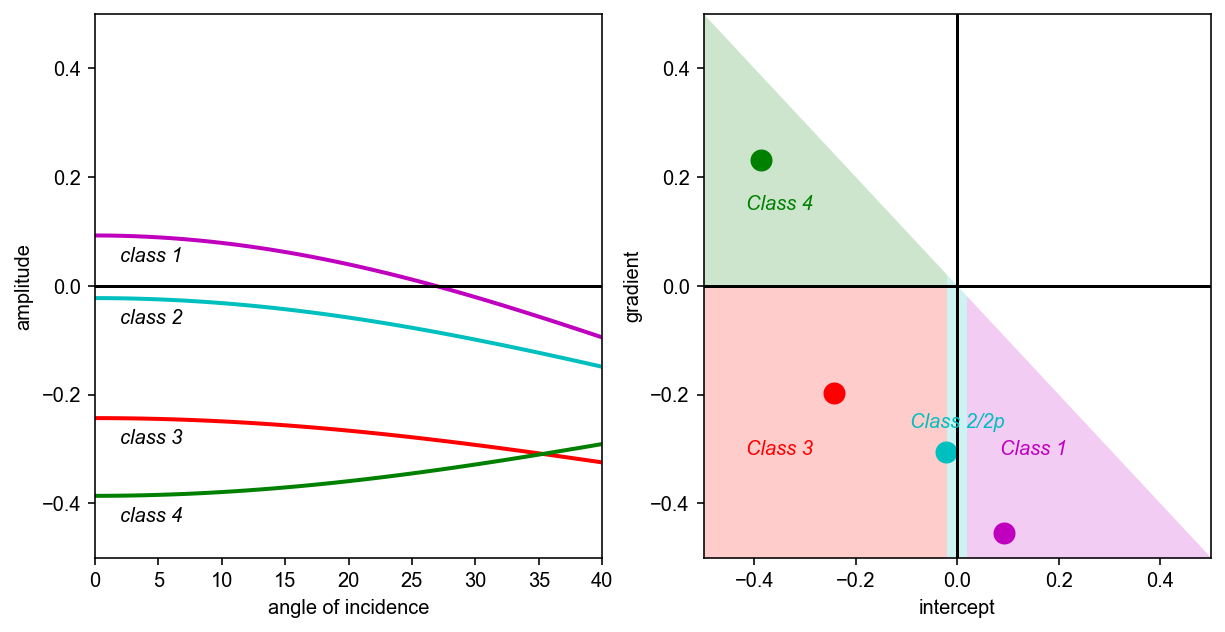

In [5]:
make_avoclasses()

## AVO explorer

`avomod1` is the main function that allows the user to explore AVO classes by studying the reflectivity (amplitude) variations with angle of incidence at an interface between two half-spaces.

The syntax is:

```
avomod1(vp1, vs1, rho1, vp2, vs2, rho2, angmin=0, angmax=30, polarity='normal', black=False, mx=0.5)
```

The upper medium is characterized by the elastic properties `vp1`, `vs1`, `rho1` (P and S-wave velocity in m/s, density in g/cc) and the lower medium by `vp2`, `vs2`, `rho2`.

The maximum angle of incidence in degrees is `angmax`.

Optional parameters are `polarity` that when set to `normal` means SEG-normal, i.e. increase in acoustic impedance is a peak or positive number; `black` is a boolean flag to draw the synthetic seismogram in black and white when set to `True`, otherwise peaks are blue and troughs are red. Finally, `mx` controls the scale of the intercept and gradient crossplot as well as the vertical scale (i.e., reflection magnitude) of the AVO plot.

We can use the elastic properties from the above array defining the various classes or input our own values:

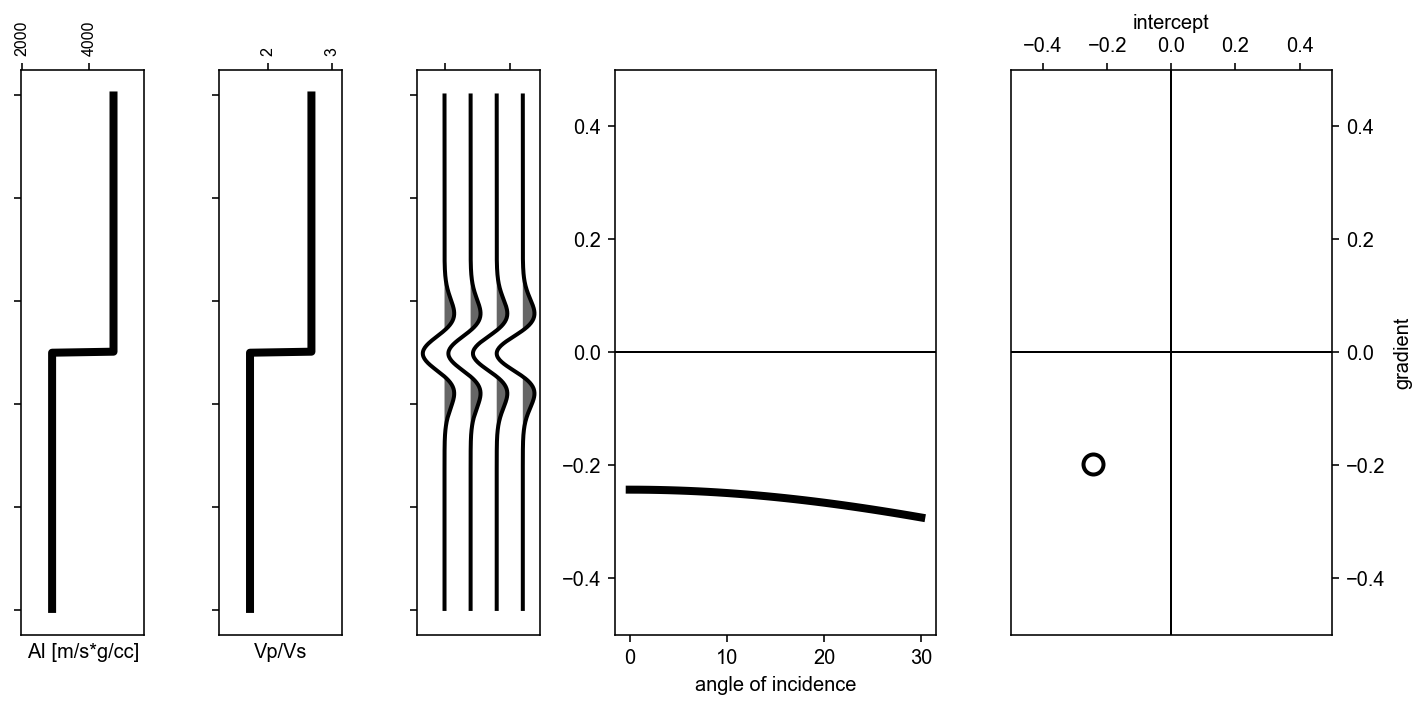

In [6]:
avomod1(shale[2,0],shale[2,1],shale[2,2],ssgas[2,0],ssgas[2,1],ssgas[2,2],angmin=0,angmax=30,polarity='normal',black=True)

To make it easier to investigate the predefined AVO classes and how they change according to fluid content and porosity variations, use `make_avo_explorer`, that also allows the user to change the saturating fluid in the sand (lower half-space) and its porosity.

In the plot below, *black* is always brine, *red* is either gas or oil according to the selection in the input parameters.

Porosity variations should stay within a range of 10% positive or negative variations, i.e. from -0.1 to +0.1.

Shale:  Vp=2192, Vs=818, rho=2.16
Sand (brine): Vp=2134, Vs=860, rho=2.11, porosity=0.33
Sand (gas): Vp=1521, Vs=911, rho=1.88


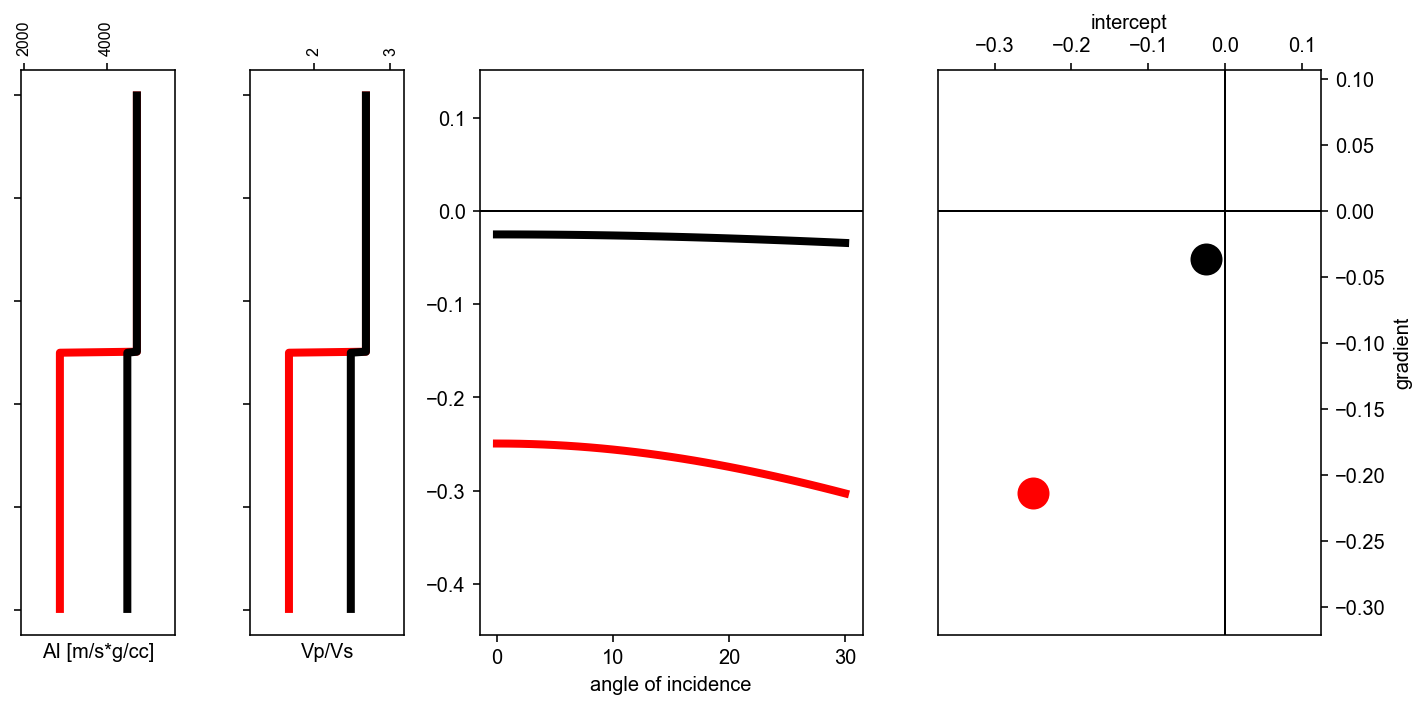

In [7]:
make_avo_explorer(avoclass=3, fluid='gas', phimod=0)